<a href="https://colab.research.google.com/github/jihyeon602/CV-practice/blob/main/%5B%EC%8B%A4%EC%8A%B53%5D_%EB%8F%84%EB%A1%9C%EC%A3%BC%ED%96%89_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%9C_Panoptic_Segmentation_(%EC%A0%95%EB%8B%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [실습3] 도로주행 데이터를 활용한 Panoptic Segmentation
---
이번 실습에선 Semantic, Instance Segmentation 모델을 활용해 Panoptic Segmentation을 수행합니다.

## 라이브러리 import
Semantic segmentation 실습에 사용할 라이브러리들을 import 합니다.
* `torch, torchvision`: Pytorch 및 이미지 처리를 위한 표준 라이브러리입니다.
* `segmentation_models_pytorch`: 다양한 Segmentation을 위한 라이브러리입니다.
* `albumentations`: 이미지 증강 및 변환을 위한 라이브러리입니다.
* `sklearn.model_selection.KFold`: 데이터를 K개의 부분으로 나누어 교차 검증을 수행하는 데 사용됩니다.
* `pycocotools.mask`: COCO 데이터셋 형식의 마스크 처리를 위한 도구입니다.
* `matplotlib.pyplot, PIL.Image`: 이미지 세그멘테이션 결과를 시각적으로 확인하기 위해 사용됩니다.

In [ ]:
# import pytorch
import torch
from torchvision.transforms import functional as F

# tools'
import pycocotools.mask as pycoco_mask
import albumentations as albu
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import hashlib
import random
import pickle
import json
import os
import datetime
import platform
import socket
from skimage.transform import resize

/home/leelang/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## CONFIG 설정
딥 러닝 모델 구성을 위한 구성 설정을 담은 Python 딕셔너리를 생성합니다. 여기서 정의된 설정은 모델 정의 과정에서 사용됩니다.

In [ ]:
CONFIG = {
    'device': 'cuda', # 사용할 gpu 지정
    'img_size': {
                        'height': 1024, # 이미지 높이
                        'width': 1920   # 이미지 너비
                    },
    'resize_to':{
                    'height': 512, # 이미지 높이
                    'width': 960   # 이미지 너비
                },
    'root': './',
}

## 폴더 생성
학습 과정에서 전처리한 데이터를 저장할 폴더를 생성합니다.

In [ ]:
# 전처리한 데이터를 저장할 폴더 생성
os.system(f"mkdir -p ./semantic_preprocess_data")

# 전처리한 데이터를 저장할 폴더 생성
os.system(f"mkdir -p ./instance_preprocess_data")

0

## 메타데이터 불러오기
`is_label_id_list`, `ss_label_id_list`라는 리스트에 segmentation 작업에 사용될 라벨과 해당 ID를 리스트 형태로 정의합니다. 각각의 라벨은 고유한 숫자 ID와 이름으로 구성됩니다.

`parse_meta_data`는 주어진 경로(root)에서 메타 데이터를 파싱하여 추출하는 함수입니다.데이터가 저장되어있는 'batch_02_data' 디렉토리 내의 각 날짜별 디렉토리에서 'label_ps/FR-View-CMR-Wide' 경로(전면 카메라에 촬영된 이미지의 메타데이터)에 있는 메타 데이터 파일들을 읽어들여 처리합니다. JSON 형태의 메타데이터 파일을 읽고 파싱하여 `ps_meta_ls` 리스트에 추가하고 최종적으로 NumPy 배열로 변환하여 반환합니다.

`ps_meta_array`에는 `parse_meta_data`를 활용해 'CONFIG['root']' 경로에서 메타 데이터를 로드하여 배열로 저장합니다.

In [ ]:
is_label_id_list = [(40,  "adult"), (41,  "child"), (42,  "animal"), (43,  "rider"), (44,  "personal_mobility"),
                    (45,  "wheelchair"), (46,  "stroller"), (47,  "bicycle"), (48,  "bus"), (49,  "car"), (50,  "motorcycle"),
                    (51,  "trailer"), (52,  "truck"), (53,  "unknown_vehicle"), (54,  "police_car"), (55,  "police_truck"),
                    (56,  "police_bus"), (57,  "police_motorcycle"), (58,  "police_unknown"), (59,  "fire_car"), (60,  "fire_truck"),
                    (61,  "fire_bus"), (62,  "fire_unknown"), (63,  "emergency_car"), (64,  "emergency_unknown"), (65,  "yellow_vehicle")]

ss_label_id_list = [(1 , "background" ), (2 , "unlabeled" ), (3 , "vegetation" ), (4 , "sky" ), (5 , "ego_vehicle" ),
                    (6 , "ground" ), (7 , "road" ), (8 , "rail_track" ), (9 , "sidewalk" ), (10 , "cycle_route" ),
                    (11 , "bridge" ), (12 , "fence" ), (13 , "garage" ), (14 , "guardrail" ), (15 , "tunnel" ),
                    (16 , "wall" ), (17 , "general_structure" ), (18 , "banner" ), (19 , "billboard" ), (20 , "road_edge" ),
                    (21 , "pole" ), (22 , "street_light" ), (23 , "removable_object" ), (24 , "traffic_light" ),
                    (25 , "traffic_sign" ), (26 , "line_white" ), (27 , "line_blue" ), (28 , "line_yellow" ), (29 , "rm_arrow" ),
                    (30 , "rm_character" ), (31 , "rm_number" ), (32 , "rm_figure" ), (33 , "guide_lane_blue" ),
                    (34 , "guide_lane_green" ), (35 , "guide_lane_red" ), (36 , "rm_cross" ), (37 , "stop_line" ),
                    (38 , "parking_strip" ), (39 , "speed_breaker" ), (40 , "curb" )]

def parse_meta_data(root):
    date_dirs = os.listdir(f"{root}/batch_02_data")
    ps_meta_ls = []
    for date_dir in tqdm(date_dirs):
        date_dir_path = f"{root}/batch_02_data/{date_dir}"
        if date_dir == "mini_sample":
            continue
        ps_meta_parrent_path = f"{date_dir_path}/label_ps/FR-View-CMR-Wide"
        ps_meta_file_ls = os.listdir(ps_meta_parrent_path)
        for ps_meta in ps_meta_file_ls:
            if ps_meta == ".ipynb_checkpoints":
                continue
            ps_meta_path = f"{ps_meta_parrent_path}/{ps_meta}"
            f = open(ps_meta_path)
            ps_meta = json.load(f)
            ps_meta_ls.append(ps_meta)
    return np.array(ps_meta_ls)

ps_meta_array = parse_meta_data(CONFIG['root'])

100%|██████████| 10/10 [00:00<00:00, 44.23it/s]


## 데이터 셋 정의
이미지 데이터를 읽고, 해당 이미지에 대한 semantic 레이블에 해당하는 마스크를 생성하여 학습에 사용할 수 있게 전처리하는 과정입니다.

`get_mask_index`: 주어진 라벨 ID에 대응하는 마스크 인덱스를 찾는 함수입니다. 각 세그멘테이션 라벨에 대한 인덱스를 얻기 위해 사용됩니다.

`parse_semantic_meta_data`: 메타 데이터에서 소스 이미지와 semantic 마스크를 파싱하는 함수입니다. 소스 이미지는 파일 경로에서 로드되며, semantic 마스크는 메타 데이터에 정의된 각 라벨에 따라 생성됩니다. `pycocotools.mask.decode`를 활용해 메타 데이터에 있는 인코딩된 마스크를 실제 이진 마스크로 변환합니다.

`to_tensor`: 이미지와 마스크를 PyTorch 텐서 형식으로 변환하는 함수입니다.

In [ ]:
def get_mask_index(label_id_list, label_id):
    return np.where(np.array(label_id_list)[:,0] == str(label_id))[0][0]

def parse_semantic_meta_data(ps_meta):
    # get source image
    source_path = CONFIG['root'] + '/'+ ps_meta['parent_path'] +'/'+ ps_meta['filename']+'.png'
    img = Image.open(source_path)
    img = np.array(img)

    # get semantic masks
    semantic_masks = np.zeros([CONFIG['img_size']['height'], CONFIG['img_size']['width'], len(ss_label_id_list)])
    ps_meta['parent_path']
    for annotation in ps_meta['annotations']:
        if annotation['isthings'] == 1:
            continue
        mask = pycoco_mask.decode(annotation['points'])
        label_id = annotation["label_id"]
        mask_index = get_mask_index(ss_label_id_list, label_id)
        semantic_masks[:,:, mask_index] = pycoco_mask.decode(annotation['points'])
    return img, semantic_masks

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1)

### Semantic Segmentation Dataset
Semantic Segmentation을 위한 데이터셋 `SemanticSegmentationDataset`을 정의합니다.
* __init__: `ps_meta_ls`를 입력받아 데이터셋을 초기화하는 생성자입니다. `albumentation`라이브러리를 활용해 이미지와 마스크의 크기를 조정하고 재배열합니다.
* __len__: 데이터셋의 전체 길이(데이터 항목의 수)를 반환합니다.
* sha256_hash: 문자열을 입력받아 SHA-256 해시를 생성합니다. 이 메서드를 사용해 원본 이미지 경로를 인코딩하여 데이터의 키로 사용합니다.
* __getitem__: PyTorch 데이터셋 인터페이스의 일부로, 인덱스에 해당하는 데이터 항목을 반환합니다.

In [ ]:
class SemanticSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self,
                 ps_meta_ls = None,
                 resize_to = CONFIG['resize_to'],
        ):
        self.ps_meta_ls = ps_meta_ls
        self.resize_to = resize_to
        self.resize =  albu.Compose([
                                  albu.Resize(height = self.resize_to['height'],
                                              width = self.resize_to['width']),
                               ])
        self.to_tensor = albu.Compose([
                                  albu.Lambda(image = to_tensor, mask = to_tensor),
                               ])

    def __len__(self):
        return len(self.ps_meta_ls)

    def sha256_hash(self, input_string):
        # SHA-256 해시 객체 생성
        hash_object = hashlib.sha256()
        # 입력 문자열을 바이트로 변환하고 해시 계산
        hash_object.update(input_string.encode())
        # 해시 값을 16진수 문자열로 변환
        hash_hex = hash_object.hexdigest()
        # 32바이트 길이로 자르기 (SHA-256은 기본적으로 32바이트 출력을 생성)
        return hash_hex[:32]


    def __getitem__(self,idx):
        ps_meta = self.ps_meta_ls[idx]
        source_path = CONFIG['root'] + '/' + ps_meta['parent_path'] +'/'+ ps_meta['filename']+'.png'

        # 원본이미지 경로를 sha256 인코딩하여 32개의 문자열 생성 -> 데이터의 키로 사용
        hashed_string = self.sha256_hash(source_path)

        # (전처리된 이미지, 타켓) 데이터를 {hashed_string}.pickle 이라는 이름으로 저장
        preprocess_data_path = f'./semantic_preprocess_data/{hashed_string}.pickle'
        if os.path.exists(preprocess_data_path):
            with open(preprocess_data_path, 'rb') as f:
                # 존재하면 저장된 값을 사용
                data = pickle.load(f)
                img, mask = data
            return img, mask

        img, semantic_masks = parse_semantic_meta_data(ps_meta)
        img = img / 255
        mask = semantic_masks
        if self.resize:
            sample = self.resize(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']

        # reshape for converting to tensor (모두 적용)
        sample = self.to_tensor(image=img, mask=mask)
        img, mask = sample['image'], sample['mask']

        img = img.astype('float32')
        mask = mask != 0

        with open(preprocess_data_path, 'wb') as handle:
            data = (img, mask)
            pickle.dump(data, handle)

        return img, mask

### Instance Segmentation Dataset
* `InstanceSegmentationDataset` 클래스
    * `__init__`: `ps_meta_ls`를 입력받아 인스턴스 분할 데이터셋을 초기화하는 생성자입니다.
    * `get_box`: 주어진 마스크로부터 바운딩 박스를 추출합니다. 계산된 바운딩 박스는 모델 학습 중 각 객체의 위치와 크기를 학습하는 데 활용됩니다.
    * `sha256_hash`: 문자열을 입력받아 SHA-256 해시를 생성합니다. 이 메서드를 사용해 원본 이미지 경로를 인코딩하여 데이터의 키로 사용합니다.
    * `get_img_target`: 주어진 인덱스에 대한 이미지와 타겟(레이블)을 로드하고 전처리합니다. 병목 방지를 위해 한번 전처리한 데이터는 instance_preprocess_data 경로에 저장하고 필요할 때 다시 불러와서 사용합니다.
    * `__getitem__`: PyTorch 데이터셋 인터페이스의 일부로, 인덱스에 해당하는 데이터 항목을 반환합니다.
    * `__len__`: 데이터셋의 전체 길이(데이터 항목의 수)를 반환합니다.

In [ ]:
class InstanceSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, ps_meta_ls):
        self.ps_meta_ls = ps_meta_ls
        self.height = CONFIG['img_size']['height']
        self.width = CONFIG['img_size']['width']

    def get_box(self, a_mask):
        # 주어진 mask로부터 bbox 추출
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1]) + 0.01
        ymin = np.min(pos[0])
        ymax = np.max(pos[0]) + 0.01
        return [xmin, ymin, xmax, ymax]

    def sha256_hash(self, input_string):
        # SHA-256 해시 객체 생성
        hash_object = hashlib.sha256()
        # 입력 문자열을 바이트로 변환하고 해시 계산
        hash_object.update(input_string.encode())
        # 해시 값을 16진수 문자열로 변환
        hash_hex = hash_object.hexdigest()
        # 32바이트 길이로 자르기 (SHA-256은 기본적으로 32바이트 출력을 생성)
        return hash_hex[:32]

    def get_img_target(self, idx):
        ps_meta = self.ps_meta_ls[idx]
        source_path = f"{CONFIG['root']}/{ps_meta['parent_path']}/{ps_meta['filename']}.png"

        # 원본이미지 경로를 sha256 인코딩하여 32개의 문자열 생성 -> 데이터의 키로 사용
        hashed_string = self.sha256_hash(source_path)

        # (전처리된 이미지, 타켓) 데이터를 {hashed_string}.pickle 이라는 이름으로 저장
        preprocess_data_path = f"instance_preprocess_data/{hashed_string}.pickle"

        # 이전에 전처리된 데이터가 존재하는 지 확인
        if os.path.exists(preprocess_data_path):
            with open(preprocess_data_path, 'rb') as f:
                # 존재하면 저장된 값을 사용
                data = pickle.load(f)
                img, target = data
            return img, target

        # 전처리된 데이터가 존재하지 않으면 새롭게 생성,
        # 저장 후 반환
        # 이미지 array 생성
        img = Image.open(source_path)
        img = np.array(img)

        n_objects = 0
        for i, annotation in enumerate(ps_meta['annotations']):
            if annotation['isthings']:
                n_objects += 1

        masks = np.zeros((self.height, self.width, n_objects), dtype=np.uint8)
        boxes = []
        labels = []
        i = 0
        for annotation in ps_meta['annotations']:
            if annotation['isthings']:
                a_mask = pycoco_mask.decode(annotation['points'])
                a_mask = Image.fromarray(a_mask)
                a_mask = np.array(a_mask) > 0
                masks[:, :, i] = a_mask
                boxes.append(self.get_box(a_mask))
                labels.append(annotation['label_id'] - 40)
                i += 1
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.bool)
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
         }

        with open(preprocess_data_path, 'wb') as handle:
            data = (img, target)
            pickle.dump(data, handle)
        return img, target


    def __getitem__(self, idx):
        img, target = self.get_img_target(idx)
        img = F.to_tensor(img)
        target['masks'] = target['masks'].permute(2,0,1)
        return img, target

    def __len__(self):
        return len(self.ps_meta_ls)

## 세그멘테이션 결과 시각화
* `make_colormap`: 지정된 숫자만큼의 색상을 생성하여 컬러맵을 반환합니다.
* `get_label_image`: 레이블 맵과 RGB 색상을 받아 해당 레이블에 색상을 적용한 이미지를 생성합니다. alpha 매개변수로 투명도를 조절합니다.

In [ ]:
def make_colormap(num=256):
    num += 1
    def bit_get(val, idx):
        return (val >> idx) & 1
    colormap = np.zeros((num, 3), dtype=int)
    ind = np.arange(num, dtype=int)
    for shift in reversed(list(range(8))):
        for channel in range(3):
            colormap[:, channel] |= bit_get(ind, channel) << shift
        ind >>= 3
    return colormap[1:]

def get_label_image(label_map, rgb_color, alpha):
    label_map = label_map[np.newaxis, :]
    label_image = np.concatenate(
        [label_map * rgb_color[0] / 255,
        label_map * rgb_color[1]/ 255,
        label_map * rgb_color[2]/ 255,
        (label_map == 1) * alpha],
    axis = 0).transpose(1,2,0)
    return label_image

### [TODO] Semantic, Instance segmentation 예측
Segmentation 모델을 활용해 샘플에 대한 예측을 수행하는 함수 `load_semantic_sample`와 `load_instance_sample`을 완성합니다.

* `load_semantic_sample`은 semantic segmentation 샘플을 로드하고 모델을 사용하여 예측을 수행하는 함수입니다. 주어진 semantic 샘플에 대해 모델을 사용하여 예측을 수행하고 예측된 마스크와 실제 마스크를 반환합니다. **예측 과정에는 모델의 forward 메소드를 사용하며** 결과는 적절한 크기로 resizing 됩니다.
* `load_instance_sample`은 instance segmentation 샘플을 로드하고 모델을 사용하여 예측을 수행하는 함수입니다. 주어진 instance 샘플에 대해 모델을 사용하여 예측을 수행하고 예측된 마스크와 레이블, 그리고 실제 마스크와 레이블을 반환합니다. **예측 과정에서는 모델의 forward 메소드를 사용하며** 예측된 마스크는 지정된 임계값을 기반으로 이진화됩니다.

In [ ]:
def load_semantic_sample(
    semantic_sample,
    semantic_model
):
    semantic_x = torch.from_numpy(semantic_sample[0][np.newaxis, ...]).to(CONFIG["device"])
    # [TODO] forward 메서드를 사용하여 semantic_model로 추론 진행
    with torch.no_grad():
        semantic_pred_masks = semantic_model.forward(semantic_x)
    semantic_pred_masks = semantic_pred_masks.detach().cpu().numpy()[0]
    semantic_pred_masks_max = semantic_pred_masks.max(axis = 0)
    semantic_pred_masks = (semantic_pred_masks >= semantic_pred_masks_max)
    # resize
    semantic_pred_masks = semantic_pred_masks.transpose(1,2,0)
    semantic_gt_masks = semantic_sample[1].transpose(1,2,0)

    semantic_pred_masks = resize(semantic_pred_masks, (CONFIG['img_size']['height'], CONFIG['img_size']['width']))
    semantic_gt_masks = resize(semantic_gt_masks, (CONFIG['img_size']['height'], CONFIG['img_size']['width']))

    semantic_pred_masks = semantic_pred_masks.transpose(2,0,1)
    semantic_gt_masks = semantic_gt_masks.transpose(2,0,1)
    return semantic_pred_masks, semantic_gt_masks

def load_instance_sample(
    instance_sample,
    instance_model,
    threshold = 0.5
):
    instance_x = torch.unsqueeze(instance_sample[0],0).to(CONFIG['device'])
    instance_gt_masks = instance_sample[1]['masks'].numpy()
    # [TODO] forward 메서드를 사용하여 instance_model로 추론 진행
    instance_preds = instance_model.forward(instance_x)
    instance_pred_masks = instance_preds[0]['masks'].detach().cpu().numpy()
    instance_pred_labels = instance_preds[0]['labels'].detach().cpu().numpy()
    instance_pred_masks = (instance_pred_masks >= threshold)
    instance_gt_masks = instance_gt_masks.astype(float)#.transpose(1,2,0)
    instance_pred_masks = instance_pred_masks[:10,0,:,:].astype(float)#.transpose(1,2,0)
    return instance_pred_masks, instance_pred_labels, instance_gt_masks, instance_pred_masks

`get_color_map`은 instance 및 semantic segmentation 결과에 대한 컬러 맵을 생성하는 함수입니다. 이 함수는 예측된 및 실제 semantic, instance segmentation 마스크를 입력으로 받아 각 영역에 대해 고유한 색상을 할당합니다.

In [ ]:
def get_color_map(
    semantic_pred_masks,
    semantic_gt_masks,
    instance_pred_masks,
    instance_pred_labels,
    instance_gt_masks,
):
    if instance_pred_masks.shape[0] > instance_gt_masks.shape[0]:
        color_num = instance_pred_masks.shape[0]
    else:
        color_num = instance_gt_masks.shape[0]

    colors = make_colormap(color_num + semantic_gt_masks.shape[0])

    instance_gt_color_map = {}
    instance_pred_color_map = {}
    instance_pred_masks_idx_ls = list(np.arange(instance_pred_masks.shape[0]))
    for i in range(instance_gt_masks.shape[0]):
        instance_gt_mask = instance_gt_masks[i]
        instance_intersection = ((instance_pred_masks == instance_gt_mask) * instance_gt_mask).sum(axis=1).sum(axis=1)
        instance_pred_mask_idx = instance_intersection.argmax()
        instance_gt_color_map[i] = colors[i]
        instance_pred_color_map[instance_pred_mask_idx] = colors[i]
        if instance_pred_mask_idx in instance_pred_masks_idx_ls:
            instance_pred_masks_idx_ls.remove(instance_pred_mask_idx)

    for i in range(len(instance_pred_masks_idx_ls)):
        instance_pred_color_map[instance_pred_masks_idx_ls[i]] = colors[i + instance_gt_masks.shape[0]]

    semantic_color_map = {}
    for i in range(semantic_gt_masks.shape[0]):
        semantic_color_map[i] = colors[color_num + i]

    return instance_pred_color_map, instance_gt_color_map, semantic_color_map

## Panoptic Segmentation 결과 시각화
* `show_overray_img_semantic_instance`은 이미지 위에 instance 및 semantic segmentation 마스크를 오버레이하여 보여주는 함수입니다. 이 함수는 주어진 이미지에 instance 및 semantic 세그멘테이션 마스크를 시각적으로 표시하여 segmentation 영역을 확인할 수 있습니다.
* `show_pred_gt_img`는 예측 결과의 panoptic segmentation 마스크와 원본 이미지를 겹쳐서 segmentation 결과를 확인하고 ground truth와 비교할 수 있도록 하는 함수입니다.

### [TODO] Panoptic Segmentation 결과 시각화를 위한 Semantic mask 전처리
Panoptic segmentation을 위해선 객체에 대해선 instance, 배경에 대해선 semantic segmentation 결과를 활용해야 합니다. `show_overray_img_semantic_instance`함수에서 instance mask가 존재하는 부분의 semantic mask는 제거하는 코드를 완성하세요.

In [ ]:
# show model prediction
def show_overray_img_semantic_instance(
    instance_masks,
    semantic_masks,
    instance_color_map,
    semantic_color_map,
    img,
    title,
    alpha = 0.5):

    # instance 결과가 0인 부분의 semantic 결과만 유지
    # None을 지우고 semantic masks에서 instance_masks가 0인 부분만을 남기는 코드를 작성하세요
    semantic_masks = semantic_masks * (instance_masks.sum(axis= 0) ==0)
    plt.imshow(img)
    for i in range(instance_masks.shape[0]):
        plt.imshow(get_label_image(instance_masks[i], instance_color_map[i], alpha = alpha))
    for i in range(semantic_masks.shape[0]):
        if semantic_masks[i].sum() != 0:
            plt.imshow(get_label_image(semantic_masks[i], semantic_color_map[i], alpha = alpha))
    plt.title(title)
    plt.show()

# 앞서 구현한 함수들을 활용해 최종 panoptic segmentation 결과 확인
def show_pred_gt_img(
                ps_meta_array,
                sample_idx,
                semantic_model,
                instance_model
                ):

    semantic_dataset = SemanticSegmentationDataset(
        ps_meta_array
    )
    instance_dataset = InstanceSegmentationDataset(
        ps_meta_array
    )

    semantic_sample = semantic_dataset[sample_idx]
    instance_sample = instance_dataset[sample_idx]

    sample_image = instance_sample[0].numpy().astype(float).transpose(1,2,0)

    semantic_pred_masks, semantic_gt_masks = load_semantic_sample(
        semantic_sample,
        semantic_model
    )

    instance_pred_masks, instance_pred_labels, instance_gt_masks, instance_pred_masks = load_instance_sample(
        instance_sample,
        instance_model,
        threshold = 0.5
    )

    instance_pred_color_map, instance_gt_color_map, semantic_color_map = get_color_map(
        semantic_pred_masks,
        semantic_gt_masks,
        instance_pred_masks,
        instance_pred_labels,
        instance_gt_masks,
    )

    show_overray_img_semantic_instance(
        instance_gt_masks,
        semantic_gt_masks,
        instance_gt_color_map,
        semantic_color_map,
        sample_image,
        "Grount Truth Panoptic"
    )

    show_overray_img_semantic_instance(
        instance_pred_masks,
        semantic_pred_masks,
        instance_pred_color_map,
        semantic_color_map,
        sample_image,
        "Model Prediction Panoptic"
    )

## 모델 불러오기
이전 실습에서의 학습을 통해 만들어진 semantic, instance segmentation 모델들을 불러와 panoptic segmentation에 활용합니다.

### [TODO] Semantic, Instance Segmentation 모델 불러오기
실습파일과 같이 저장되어있는 `best_semantic_segmentation_model.pth`과 `best_semantic_segmentation_model.pth`은 각각 이전 실습에서 예시로 주어졌던 학습이 많이 이루어진 semantic, instance segmentation 모델이 저장된 파일입니다. 이 파일들을 활용해 모델들을 불러옵니다.
* 이전 실습에서 직접 학습을 수행한 모델을 업로드해 활용해도 좋습니다. (채점에 영향은 없습니다)
* 모델을 불러올 장치인 map_location은 앞서 설정한 `CONFIG["device"]`을 활용합니다.

In [ ]:
# [TODO] ss, is 모델 불러오기
semantic_model = torch.load("best_semantic_segmentation_model.pth",  weights_only=False, map_location=CONFIG["device"])
instance_model = torch.load("best_instance_segmentation_model.pth",  weights_only=False, map_location=CONFIG["device"])

semantic_model.eval()
instance_model.eval()
data_size = len(ps_meta_array)

# 결과 시각화

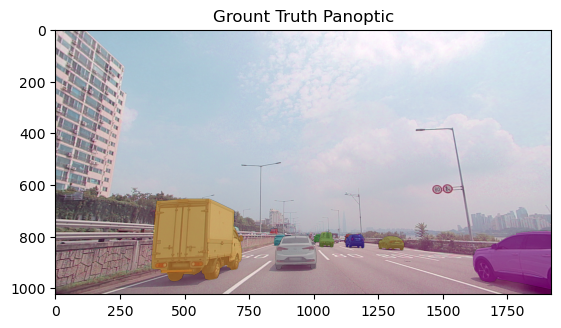

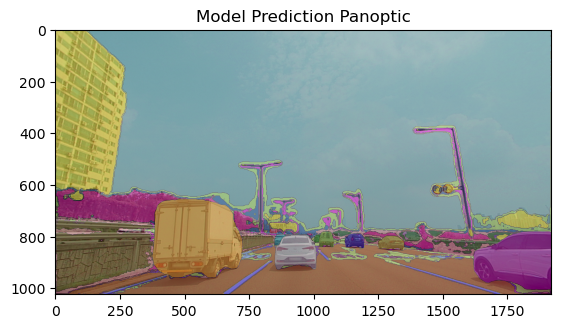

In [ ]:
sample_idx = random.randrange(0, data_size)
show_pred_gt_img(
    ps_meta_array,
    sample_idx,
    semantic_model,
    instance_model
)

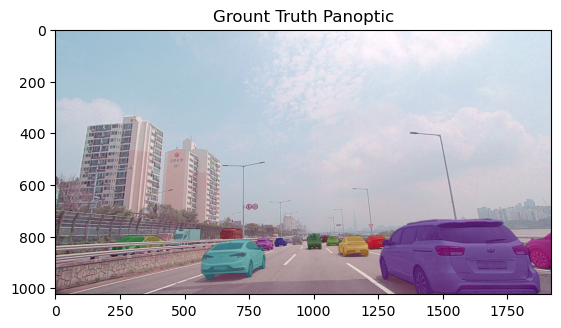

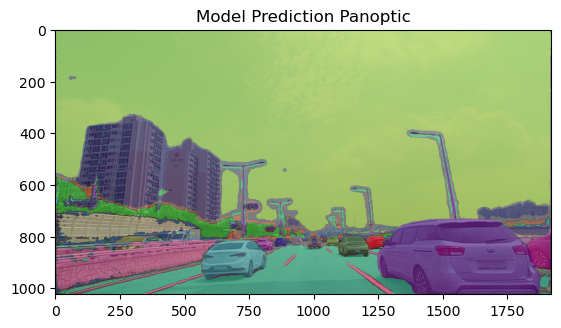

In [ ]:
sample_idx = random.randrange(0, data_size)
show_pred_gt_img(
    ps_meta_array,
    sample_idx,
    semantic_model,
    instance_model
)

# 채점
채점을 위한 코드입니다. 아래 코드를 실행하시고 우측 상단의 제출 버튼을 누르면 채점이 진행됩니다.
* 위의 실습 지시사항을 모두 올바르게 수행해야 채점이 진행됩니다.
* 채점 코드를 임의로 수정할 시 채점이 올바르게 진행되지 않습니다.

In [ ]:
import inspect
import json

student_answers = {}

student_answers["problem_1"] = inspect.getsource(load_semantic_sample) + ' ' + inspect.getsource(load_instance_sample)
student_answers["problem_2"] = inspect.getsource(show_overray_img_semantic_instance)
student_answers["problem_3"] = str(type(semantic_model)) + ' ' + str(type(instance_model))

with open("result.json", "w") as f:
    json.dump(student_answers, f)

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright 2023. Elice Inc. all rights reserved.</span>